In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.xgb_forecasting import XGBoostModel
from src.lstm_forecasting import LSTMTimeSeries
from sklearn.metrics import mean_squared_error
from src.preprocess import *
# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

In [3]:
# Champs-Elysees
df_champs_lstm = pipeline(champs_elysees_df, window=3, fill_hours=True,fillna=True)
# fill_hours=True → add missing hourly timestamps to ensure continuous time sequences (important for LSTM)  
# fillna=True → fill missing (NaN) values in the existing data

# Sts peres
sts_peres_df = treat_nan_sts_peres(sts_peres_df) # sts_peres has some months missing in the middle, we decided to aggregate the data before and after the gap
df_sts_peres_xgb = pipeline(sts_peres_df,window=3,fill_hours=False,fillna=True)

# Convention
convention_df = treat_nan_convention(convention_df) # convention has a lot of missing data in the begining, we decided to only keep some data
df_convention_xgb = pipeline(convention_df,window=3,fill_hours=False,fillna=True)

In [4]:
df_test_champs_2025, df_test_convention_2025, df_test_peres_2025 = create_test_dataset(df_champs_lstm,df_convention_xgb,df_sts_peres_xgb)


after examination :

    Champs-elysees --> LSTM

    convention --> xgb

    sts peres --> xgb

In [5]:
targets = ['Débit horaire', "Taux d'occupation"]

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb_sts_peres = df_sts_peres_xgb.copy()

lags_hours = [72, 168]  # 3 days and 1 week lags
df_xgb_sts_peres, features_xgb_sts_peres = create_lag_features(df_xgb_sts_peres, targets=targets, lags_hours=lags_hours)

features_xgb_sts_peres += features_xgb


xgb_model_sts_peres = XGBoostModel(df_xgb_sts_peres, features_xgb_sts_peres, targets)
xgb_model_sts_peres.full_train()


Full training completed on all data.


{'Débit horaire': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...),
 "Taux d'occupation": XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
      

In [24]:
X_test=df_test_peres_2025[features_xgb_sts_peres]
y_pred=xgb_model_sts_peres.predict_final(X_test)
print(y_pred)

    pred_Débit horaire  pred_Taux d'occupation
0           446.329926                5.922583
1           443.059937                5.478129
2           381.887787                5.312860
3           332.424438                3.971147
4           240.098236                2.985255
5           175.771133                2.224343
6           141.932785                1.816484
7           138.812912                1.738194
8           138.482498                2.015516
9           162.371872                2.818451
10          252.280685                3.935165
11          330.627106                5.544608
12          346.880493                6.662846
13          448.356079                7.063135
14          481.649628                7.611346
15          532.339417                9.043620
16          561.787598                9.266769
17          606.602112                9.928392
18          643.820679               10.602740
19          632.633423                9.851399
20          5

In [25]:

# --- Créer le DataFrame date/heure pour 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00", "2025-11-11 23:00", freq="H")

# --- Convertir y_pred en DataFrame ---
y_pred_df = pd.DataFrame(y_pred)
# --- Ajouter la colonne datetime ---
df_output = pd.DataFrame({
    'arc': 'Saint-Pères',  # changer selon le site si nécessaire
    'datetime': date_range,
    'debit_horaire': y_pred_df['pred_Débit horaire'],
    'taux_occupation': y_pred_df["pred_Taux d'occupation"]
})

# --- Formater la colonne datetime comme indiqué ---
df_output['datetime'] = df_output['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Exporter en CSV ---
df_output.to_csv("output_bison_fûté.csv", index=False,sep=";")


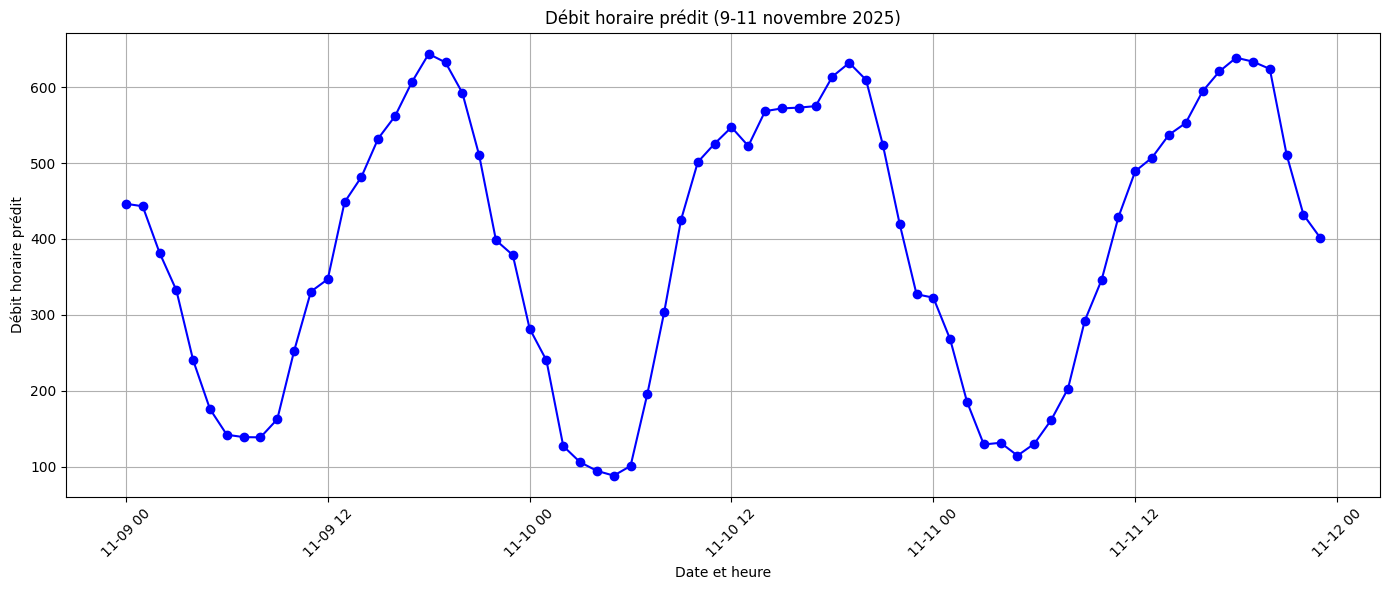

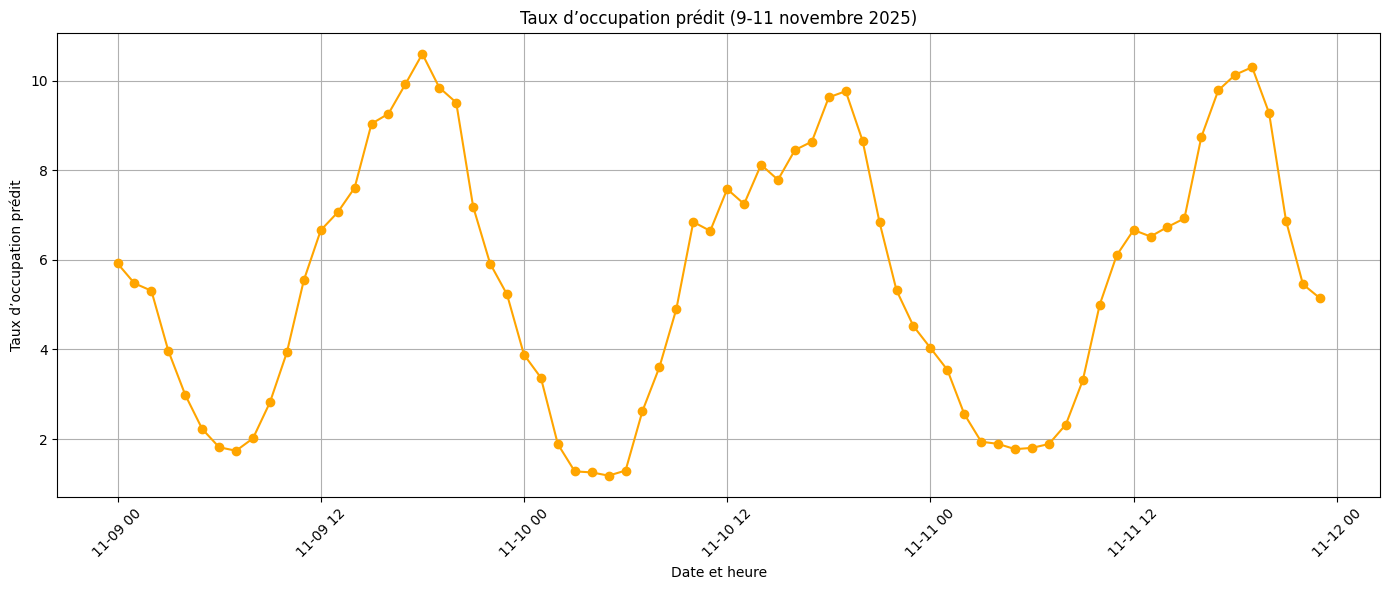

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Ajouter les prédictions y_pred ---
df_plot = pd.concat([df_plot.reset_index(drop=True), 
                     y_pred[['pred_Débit horaire', 'pred_Taux d\'occupation']].reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
targets = ['Débit horaire', "Taux d'occupation"]

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb_convention = df_convention_xgb.copy()

lags_hours = [72, 168]  # 3 days and 1 week lags
df_xgb_convention, features_xgb_convention = create_lag_features(df_xgb_convention, targets=targets, lags_hours=lags_hours)

features_xgb_convention += features_xgb


xgb_model_convention = XGBoostModel(df_xgb_convention, features_xgb_convention, targets)
xgb_model_convention.full_train()

Full training completed on all data.


{'Débit horaire': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...),
 "Taux d'occupation": XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
      

In [27]:
X_test=df_test_convention_2025[features_xgb_convention]
y_pred=xgb_model_convention.predict_final(X_test)
print(y_pred)

    pred_Débit horaire  pred_Taux d'occupation
0           304.728516                2.046026
1           284.859070                1.865903
2           248.429901                1.685680
3           200.429077                1.258523
4           153.864960                0.931386
5           124.646141                0.802754
6           133.076660                0.916052
7           143.243484                1.033199
8           151.351151                1.144840
9           178.893951                1.501822
10          269.461609                2.164385
11          354.094971                2.568502
12          415.365295                2.975810
13          498.818604                3.375182
14          540.187195                3.774956
15          565.776306                4.176995
16          566.928162                4.274318
17          576.102356                4.446877
18          573.129272                4.267839
19          566.411560                4.240976
20          5

In [28]:
# --- Lire le CSV existant (Saint-Pères déjà présent) ---
df_output = pd.read_csv("output_bison_fûté.csv",sep=";")

# --- Créer le DataFrame pour Convention ---
y_pred_convention_df = pd.DataFrame(y_pred)  # tes prédictions pour Convention

date_range_convention = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")

df_convention = pd.DataFrame({
    'arc': 'Convention',
    'datetime': date_range_convention,
    'debit_horaire': y_pred_convention_df['pred_Débit horaire'],
    'taux_occupation': y_pred_convention_df["pred_Taux d'occupation"]
})

# --- Formater la colonne datetime ---
df_convention['datetime'] = df_convention['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Concaténer les deux DataFrames (Saint-Pères + Convention) ---
df_output = pd.concat([df_output, df_convention], axis=0).reset_index(drop=True)

# --- Réexporter en CSV ---
df_output.to_csv("output_bison_fûté.csv", index=False,sep=";")


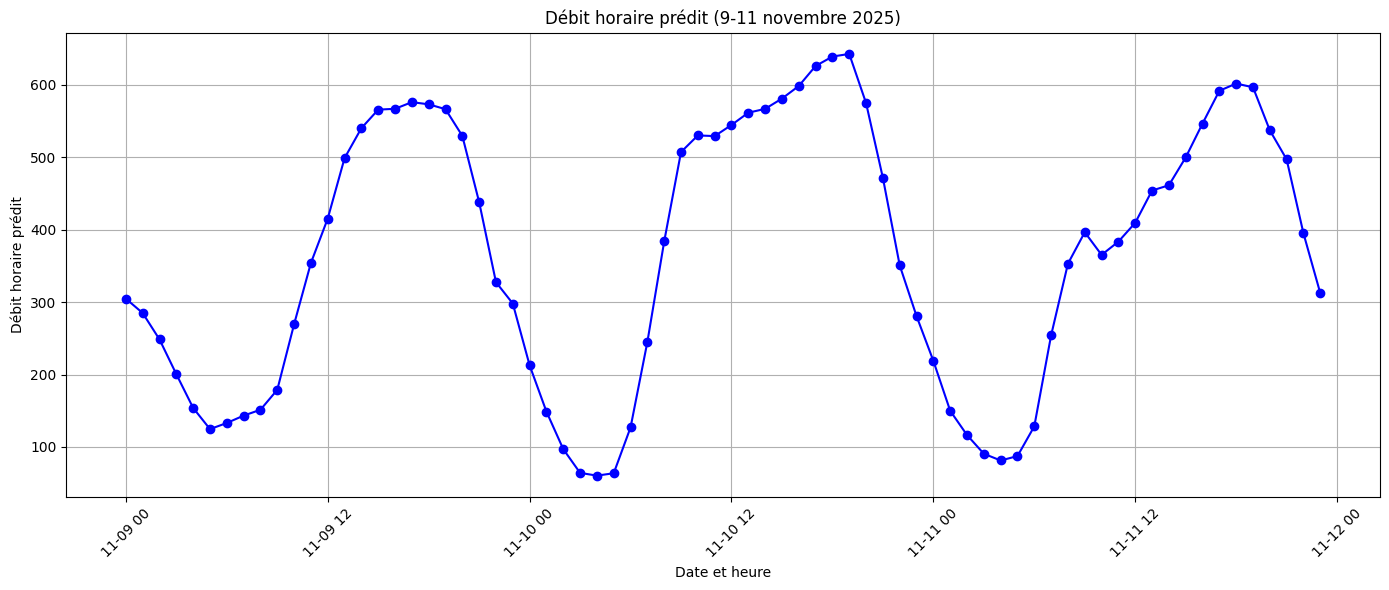

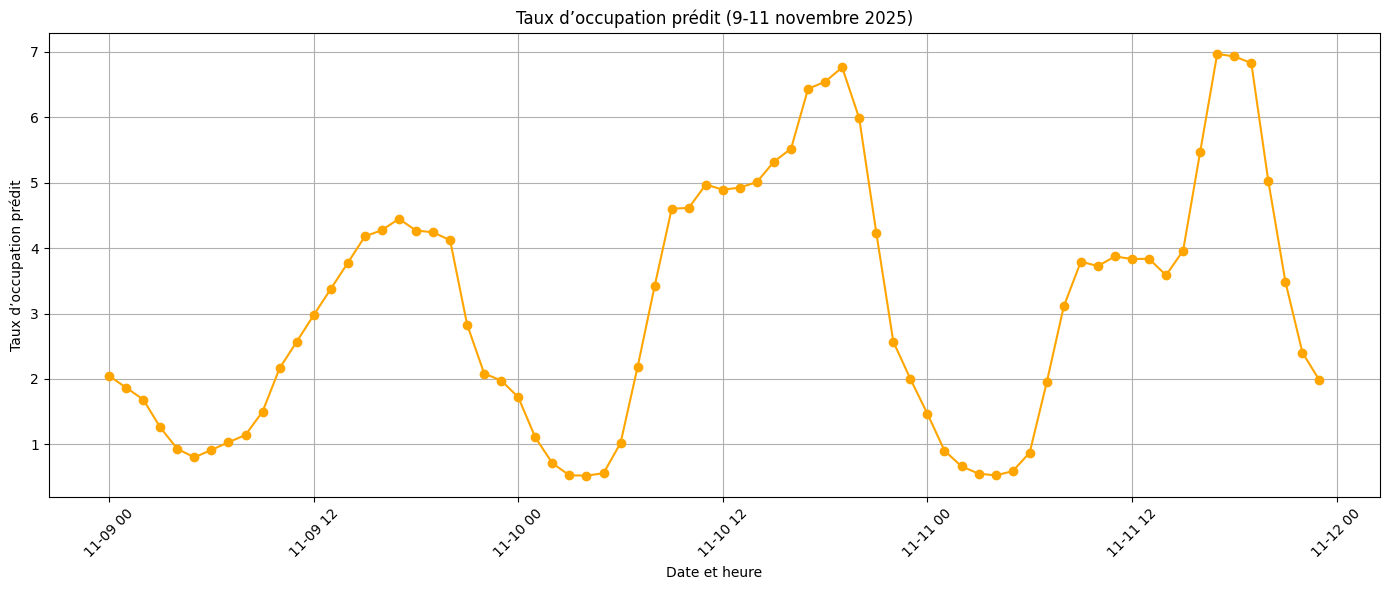

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Ajouter les prédictions y_pred ---
df_plot = pd.concat([df_plot.reset_index(drop=True), 
                     y_pred[['pred_Débit horaire', 'pred_Taux d\'occupation']].reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
targets = ['Débit horaire', "Taux d'occupation"]

features_champs = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

In [19]:
final_eval_size = 72
seq_length = 168

train_df_champs = df_champs_lstm.copy()

lstm_model_champs = LSTMTimeSeries(
    features=features_champs,
    targets=targets,
    seq_length=seq_length,
    pred_length=final_eval_size
)

lstm_model_champs.train_final(train_df_champs, epochs=30, batch_size=32)

Epoch 1/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - loss: 0.5578 - mae: 0.5430 - mape: 207.1710
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - loss: 0.3751 - mae: 0.4334 - mape: 193.4305
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - loss: 0.3259 - mae: 0.3984 - mape: 176.9087
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - loss: 0.2817 - mae: 0.3708 - mape: 166.4320
Epoch 5/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - loss: 0.2503 - mae: 0.3523 - mape: 156.0841
Epoch 6/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - loss: 0.2676 - mae: 0.3602 - mape: 168.6408
Epoch 7/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.2226 - mae: 0.3304 - mape: 154.6705
Epoch 8/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - loss: 0.2272 - mae: 0.3318 - mape: 152.8672
Epoch 9/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - loss: 0.2568 - mae: 0.3475 - mape: 162.4984
Epoch 10/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 0.2092 - mae: 0.3185 - mape: 150.5

In [31]:
# Extraire les 168 dernières heures de train pour initier la séquence
last_train_seq_df = train_df_champs[features_champs].iloc[-168:].copy()

# Vérification
print(last_train_seq_df.shape)  # doit être (168, n_features)

# Appel de la prédiction
y_pred = lstm_model_champs.predict(last_train_seq_df)  # la méthode s'occupe du reshape
print(y_pred)  # devrait être (72, n_targets)


(168, 21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[ 942.24976     19.02973  ]
 [ 925.79333     17.41904  ]
 [ 883.089       15.859141 ]
 [ 810.27734     14.120767 ]
 [ 712.14606     12.266497 ]
 [ 602.50323     10.28524  ]
 [ 500.94833      8.244768 ]
 [ 435.54468      6.798651 ]
 [ 419.84332      6.216781 ]
 [ 463.2111       6.787213 ]
 [ 546.784        8.442548 ]
 [ 643.7085      10.67583  ]
 [ 721.66766     13.349887 ]
 [ 779.0954      15.889351 ]
 [ 820.1179      18.647943 ]
 [ 859.3938      21.094252 ]
 [ 894.8036      23.413815 ]
 [ 923.63617     25.016348 ]
 [ 932.0468      25.81278  ]
 [ 924.894       25.881895 ]
 [ 905.7462      24.754398 ]
 [ 896.1226      23.385128 ]
 [ 893.9219      21.344372 ]
 [ 896.1527      19.413773 ]
 [ 888.90607     17.521545 ]
 [ 856.8574      15.749741 ]
 [ 791.24023     14.12037  ]
 [ 693.99963     12.317257 ]
 [ 578.37744     10.3488245]
 [ 471.88095      8.252641 ]
 [ 390.99875      6.221108 ]
 [ 356.7894       4.791761 ]
 [ 376.12912      4.7064

In [32]:
df_output = pd.read_csv("output_bison_fûté.csv",sep=";")


# --- Créer le DataFrame pour Champs-Élysées ---
date_range_champs = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")

df_champs = pd.DataFrame({
    'arc': 'Champs-Elysées',
    'datetime': date_range_champs,
    'debit_horaire': y_pred[:,0],
    'taux_occupation': y_pred[:,1]
})

# --- Formater la colonne datetime ---
df_champs['datetime'] = df_champs['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# --- Ajouter au CSV existant ---
df_output = pd.concat([df_output, df_champs], axis=0).reset_index(drop=True)

# --- Réexporter ---
df_output.to_csv("output_bison_fûté.csv", index=False,sep=";")


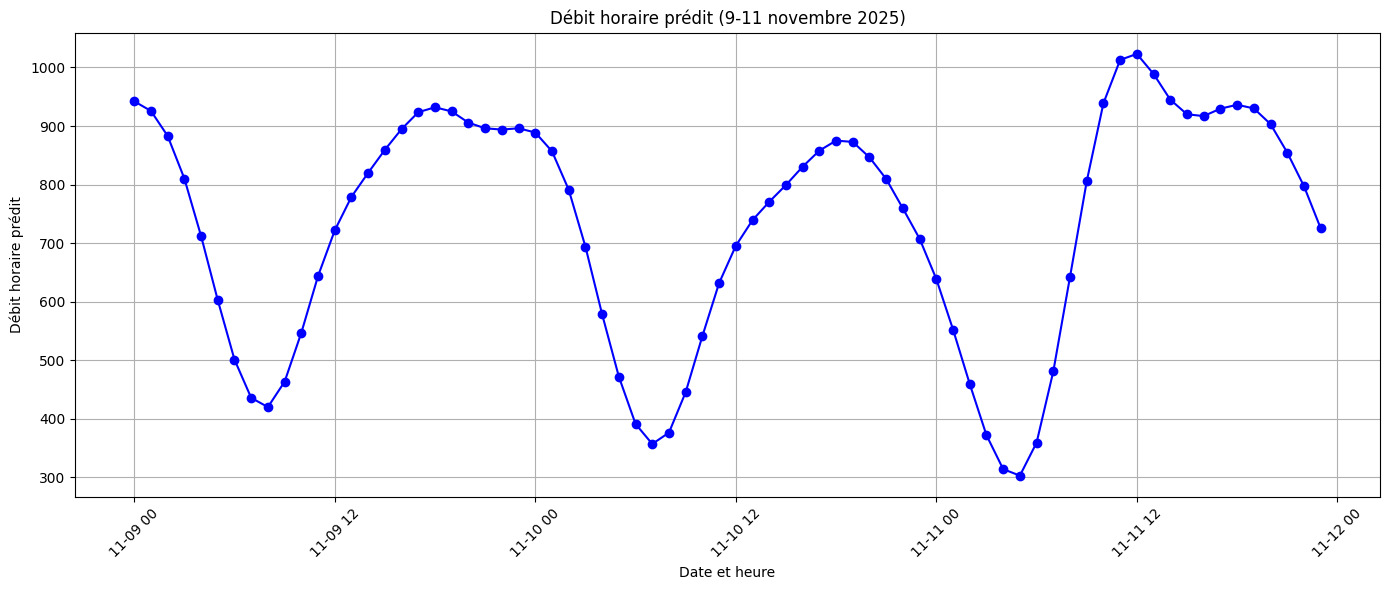

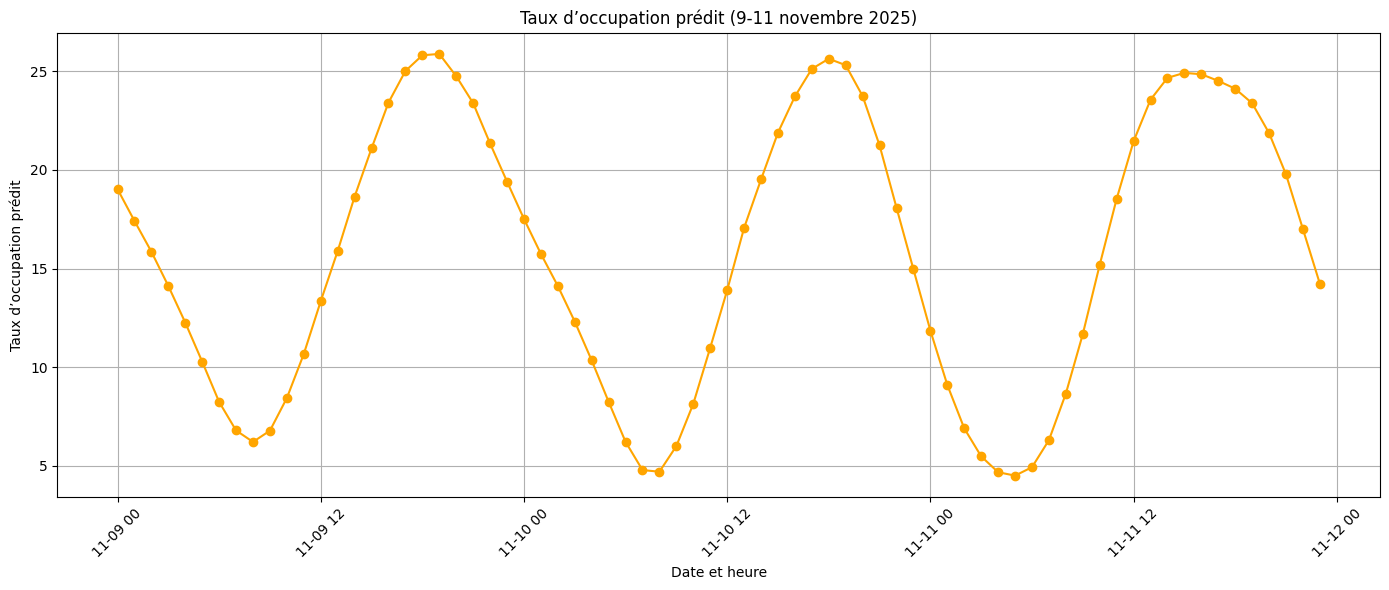

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Création du DataFrame date/heure 9-11 novembre 2025 ---
date_range = pd.date_range("2025-11-09 00:00:00", "2025-11-11 23:00:00", freq="H")
df_plot = pd.DataFrame({"date": date_range})

# --- Convertir y_pred en DataFrame et ajouter au df_plot ---
y_pred_df = pd.DataFrame(y_pred, columns=['pred_Débit horaire', 'pred_Taux d\'occupation'])
df_plot = pd.concat([df_plot.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

# --- Graphique Débit horaire ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Débit horaire'], color='blue', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Débit horaire prédit')
plt.title('Débit horaire prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graphique Taux d’occupation ---
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['pred_Taux d\'occupation'], color='orange', marker='o')
plt.xlabel('Date et heure')
plt.ylabel('Taux d’occupation prédit')
plt.title('Taux d’occupation prédit (9-11 novembre 2025)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Verify CSV

In [35]:
from datetime import datetime
from pathlib import Path

def test_format_and_export_output(output_df, output_directory, name_of_the_group):
    output_columns = {
        "arc": object,
        "datetime": object,
        "debit_horaire": float,
        "taux_occupation": float
    }

    # 1. Check relevant columns are in output dataframe
    assert sorted(list(output_df.columns)) == list(output_columns.keys()), \
        "Some columns are missing or unnecessary columns are in output"

    # 2. Check types
    for col, col_type in output_columns.items():
        assert output_df[col].dtype == col_type, f"Column {col} does not have type {col_type}"

    # 3. Check datetime string has right format
    try:
        output_df.datetime.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M"))
    except ValueError as e:
        raise e

    # 4. Check `arc` columns has right values
    expected_arcs = ["Champs-Elysées", "Convention", "Saint-Pères"]
    assert sorted(list(output_df["arc"].unique())) == expected_arcs, \
        "Output does not have expected unique values for column `arc`"

    # 5. Check dataframe has right number of rows
    assert output_df.shape[0] == 216, f"Expected number of rows is 216, output has {output_df.shape[0]}"

    # 6. Export output
    output_path = Path(output_directory) / f"output_{name_of_the_group}.csv"
    print(f"[SAVE OUTPUT] Saving output here: {output_path}")
    output_df[list(output_columns.keys())].to_csv(output_path, sep=";")



my_output=pd.read_csv("output_bison_fûté.csv",sep=";")

test_format_and_export_output(
    output_df=my_output,
    output_directory=".",  # le dossier courant
    name_of_the_group="bison_fûté"
)


[SAVE OUTPUT] Saving output here: output_bison_fûté.csv
